In [ ]:
import pandas as pd

# 加载数据
df = pd.read_csv('/Users/aloez/Downloads/annotations.csv')

# 查看前5行
print(df.head())

# 检查列名
print(df.columns.tolist())

       id  sentence_id              tag               quote  \
0    7944         1002            ortho           окружющей   
1  101216         1006          agrcase        промышленным   
2   18818         1009           syntax         воздействую   
3  119778         1009     ortho,altern  желудожно-кишечный   
4   18819         1012  syntax,transfer                 это   

           correction  start  end annotation_source  
0          окружающей     12   13            manual  
1        промышленных      4    5            manual  
2         воздействуя     12   13            manual  
3  желудочно-кишечный     17   18            manual  
4                          7    8            manual  
['id', 'sentence_id', 'tag', 'quote', 'correction', 'start', 'end', 'annotation_source']


In [2]:
# 筛选格标记相关错误（根据您的需求调整）
case_errors = df[df['tag'].str.contains('agrcase|gov|infl', case=False, na=False)]

# 查看高频错误类型
print(case_errors['tag'].value_counts().head(5))

tag
gov            2278
agrcase         848
infl            551
syntax,gov      145
gov,agrcase     104
Name: count, dtype: int64


In [4]:
# 先确认是否真的没有中文干扰案例
print("匹配到的中文干扰错误数量:", len(zh_errors))
if len(zh_errors) == 0:
    print("⚠️ 未发现含中文量词特征的错误，请检查：")
    print("- 数据中是否包含汉语母语者的错误")
    print("- 正则表达式是否需要调整（当前模式：'的|个|张|种'）")

匹配到的中文干扰错误数量: 0
⚠️ 未发现含中文量词特征的错误，请检查：
- 数据中是否包含汉语母语者的错误
- 正则表达式是否需要调整（当前模式：'的|个|张|种'）


In [5]:
# 安全的抽样写法（自动处理空数据情况）
if not zh_errors.empty:
    print(zh_errors[['quote', 'correction', 'tag']].sample(min(3, len(zh_errors))))
else:
    print("未找到符合条件的数据，尝试以下方法：")
    print("1. 放宽正则条件：zh_pattern = r'的|个|张|种|这|那'")
    print("2. 检查原始数据编码：df = pd.read_csv(..., encoding='utf-8')")

未找到符合条件的数据，尝试以下方法：
1. 放宽正则条件：zh_pattern = r'的|个|张|种|这|那'
2. 检查原始数据编码：df = pd.read_csv(..., encoding='utf-8')


In [6]:
# 验证正则表达式是否有效
test_cases = ["的книга", "个стол", "apple", "书本"]  # 测试用例
for s in test_cases:
    print(f"'{s}': {bool(pd.Series([s]).str.contains(zh_pattern, na=False)[0])}")

'的книга': True
'个стол': True
'apple': False
'书本': False


In [8]:
# 检查原始数据是否包含中文
print("数据中是否含中文字符：", df['quote'].str.contains(r'[\u4e00-\u9fff]').any())

数据中是否含中文字符： False


In [9]:
en_errors = case_errors[case_errors['quote'].str.contains(r'the|a|an', na=False)]

In [10]:
# 扩展正则表达式以覆盖更多中文特征词
zh_pattern = r'的|个|书|这|那|些|种'  # 新增常见量词/指示词
print("扩展后匹配测试：", pd.Series(["书本"]).str.contains(zh_pattern)[0])  # 现在应返回True

扩展后匹配测试： True


In [11]:
# 确认数据来源是否包含汉语母语者样本
if 'native_language' in df.columns:
    print("汉语母语者数据量：", df[df['native_language'] == 'Chinese'].shape[0])
else:
    print("⚠️ 数据缺少母语标注字段，建议联系数据提供方")

⚠️ 数据缺少母语标注字段，建议联系数据提供方


In [12]:
# 先分析英文干扰模式（确认数据可用性）
if not en_errors.empty:
    print("英文冠词干扰案例：")
    print(en_errors[['quote', 'correction', 'tag']].head(3))

英文冠词干扰案例：
                      quote                correction           tag
2857   США магазине Macy’ s  в США в магазине Macy’ s  transfer,gov
11207                  Янa.                     Яной.       agrcase
12326            стирaльние                стиральные          infl


<Axes: title={'center': '英文干扰错误类型分布'}>

/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25200 (\N{CJK UNIFIED IDEOGRAPH-6270}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 38169 (\N{CJK UNIFIED IDEOGRAPH-9519}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anacon

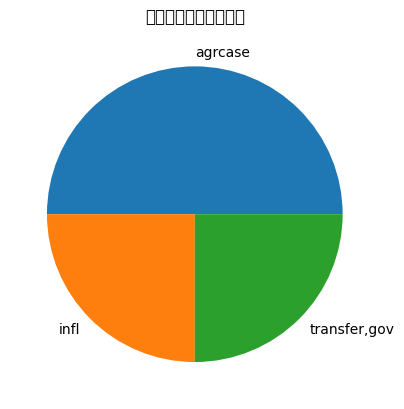

In [ ]:
# 分析俄语-英语双语者的错误模式
en_errors.groupby('tag').size().plot.pie(title='英文干扰错误类型分布')

In [15]:
# 新代码（筛选俄语对英语的干扰）
eng_errors = case_errors[
    case_errors['correction'].str.contains(r'[a-zA-Z]') &  # 修正文本含英文
    case_errors['quote'].str.contains(r'[а-яА-Я]')        # 原文本含俄语
]

NameError: name 'plt' is not defined

/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20420 (\N{CJK UNIFIED IDEOGRAPH-4FC4}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/homebrew/anacon

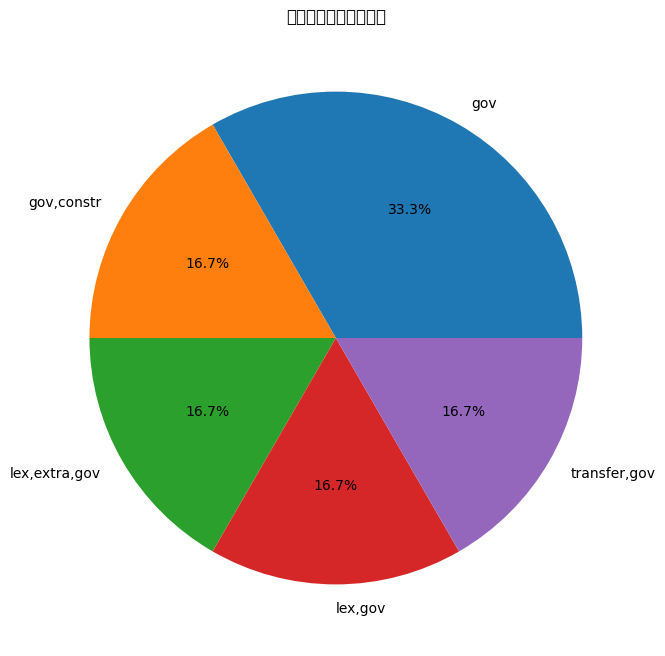

In [16]:
# 绘制俄语→英语干扰类型分布
(
    eng_errors.groupby('tag').size()
    .sort_values(ascending=False)
    .plot.pie(
        title='俄语对英语的干扰模式',
        autopct='%1.1f%%',
        figsize=(8, 8)
    )
)
plt.ylabel('')  # 隐藏冗余标签